In [1]:
%matplotlib inline
import tables as tb
import numpy as np
import pandas as pd
import json
from datetime import datetime, timedelta
import scipy.sparse as sp
import matplotlib.pyplot as plt
import tables as tb
import scipy.sparse as sp
import sqlite3 as lite

In [2]:
# DB 로드
db = tb.open_file('data/market.hdf5', mode='r')

#종목정보 불러오기
con = lite.connect('data/db.sqlite3')
products = pd.read_sql('select * from trading_product', con)
products.set_index(['group'], drop=False, inplace=True)
products = products.to_dict(orient='index')

In [22]:
def density():
    """
    density distribution
    각 가격대별 누적 거래량을 구함
    거래량은 시간차의 제곱근에 비례하여 감소함
    """
    now = np.datetime64(datetime.now()+timedelta(hours=1))
    cnt = 0
    result= dict()
    for grp in products.values():
        cnt += 1
        print(grp['name'], ' cnt: %s'%cnt)
        
        #환경변수
        source = getattr(db.root, grp['group']).Minute.read()
        tick = grp['tick_unit']
        digit = grp['decimal_places']
        
        #rawdata 불러오기
        value = source['value'] #density
        #1. inf --> 0
        value[value == np.inf] = 0 #inf 값은 0으로..
        #2. std * 15 보다 큰값 --> 0
        value[value > value.std()*15] = 0
        #3. Nan --> 0
        value[value == np.NaN] = 0
        
        price = source['price'].round(digit)
        rows = source['row']
        dates = getattr(db.root, grp['group']).DateMapper.read(field='date').astype('M8[s]')
        # price range --> column array 변경 
        # (가격 - 최소가)/가격변동단위
        columns = np.rint((price-price.min())/tick)
        
        #sparse matrix creation
        shape = (rows.max()+1, columns.max()+1)
        matrix = sp.csr_matrix((value, (rows, columns)), shape=shape)
        
        #scale factor
        delta = (now - dates)/np.timedelta64(1,'D')+1 #시간델타 - 현재가 1임
        scale = sp.diags(1/(np.sqrt(delta))) #sqrt(deltaT) diagonal matrix
        
        #normalized density distribution
        density = np.squeeze(np.asarray((scale*matrix).sum(axis=0)))
        normed_density = density/density.sum()
        x_ticks = np.arange(price.min(), price.max()+tick/2, tick).round(digit).tolist()
        array = np.array([x_ticks, normed_density])
        
        result[grp['group']] = array
    print("Done")
    return result

In [23]:
dens = density()

5Year U.S. T-Note  cnt: 1
Corn  cnt: 2
RBOB Gasoline  cnt: 3
Eurodollar  cnt: 4
10-year JGB Futures  cnt: 5
Silver  cnt: 6
ICE ORANGE JUICE  cnt: 7
ICE Gasoil  cnt: 8
FTSE 100  cnt: 9
VSTOXX  cnt: 10
2Year U.S.T-Note  cnt: 11
ICE WTI Crude  cnt: 12
Wheat  cnt: 13
Platinum  cnt: 14
Long-term Euro-BTP  cnt: 15
CAC40  cnt: 16
Rough Rice  cnt: 17
Swiss Franc  cnt: 18
SIMSCI  cnt: 19
Long Gilt  cnt: 20
Lean Hogs  cnt: 21
Live Cattle  cnt: 22
ICE Sugar  cnt: 23
Renminbi_USD/CNH  cnt: 24
TOPIX  cnt: 25
10Year U.S. T-Note  cnt: 26
Australian Dollar  cnt: 27
ICE Cotton  cnt: 28
British Pound  cnt: 29
New Zealand Dollar  cnt: 30
SGX FTSE China A50  cnt: 31
30Year U.S. T-Bond  cnt: 32
H-Share  cnt: 33
Euro Schatz  cnt: 34
Soybean Meal  cnt: 35
ICE Coffee  cnt: 36
Euro FX  cnt: 37
DAX  cnt: 38
Copper  cnt: 39
DJ Euro Stoxx 50  cnt: 40
Crude Oil (WTI)  cnt: 41
Euro Bobl  cnt: 42
Soybeans  cnt: 43
Nikkei 225 Dollar-based  cnt: 44
Euro Bund  cnt: 45
Brazilian Real  cnt: 46
Palladium  cnt: 47
Heating 

In [25]:
dens['AD']

array([[  4.76400000e-01,   4.76500000e-01,   4.76600000e-01, ...,
          1.09920000e+00,   1.09930000e+00,   1.09940000e+00],
       [  6.56181384e-08,   6.56181384e-08,   6.56181384e-08, ...,
          4.98379584e-06,   4.98379584e-06,   4.98379584e-06]])

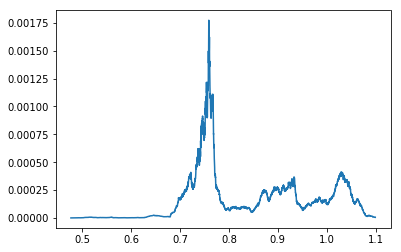

In [31]:
x,y = dens['AD']
plt.plot(x,y)